In [1]:
%load_ext sql
%sql postgresql://riyer@localhost:5094/madlib-pg94
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager

/usr/local/lib/python2.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/usr/local/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


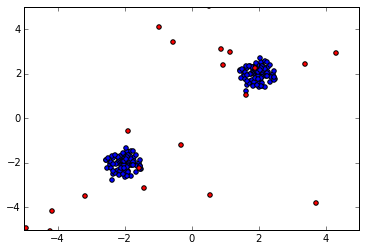

In [2]:
# Generate train data
X = 0.3 * np.random.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
X_train_D = pd.DataFrame(X_train, columns=['x1', 'x2'])

# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-7, high=7, size=(40, 2))
X_outliers_D = pd.DataFrame(X_outliers, columns=['x1', 'x2'])

b = plt.scatter(X_train[:, 0], X_train[:, 1], c='blue')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.show()

In [ ]:
%sql DROP TABLE IF EXISTS X_train_D CASCADE
%sql PERSIST X_train_D
%sql ALTER TABLE X_train_D add column X float[]
%sql update X_train_D set X = array[x1, x2]::float[]

%sql DROP TABLE IF EXISTS X_outliers_D CASCADE
%sql PERSIST X_outliers_D
%sql ALTER TABLE X_outliers_D add column X float[]
%sql update X_outliers_D set X = array[x1, x2]::float[]

In [3]:
%%sql 
DROP TABLE IF EXISTS svm_out1, svm_out1_summary, svm_out1_random CASCADE;
SELECT madlib.svm_one_class(
    'X_train_D',    -- source table
    'svm_out1',     -- output table
    'X',            -- features
    'gaussian',     -- kernel
    'gamma=1, n_components=55, random_state=3', 
    NULL,           -- grouping 
    'init_stepsize=0.1, lambda=10, max_iter=100, tolerance=0'  
    );
SELECT * FROM svm_out1; 

Done.
1 rows affected.
1 rows affected.


coef,loss,norm_of_gradient,num_iterations,num_rows_processed,num_rows_skipped,dep_var_mapping
"[-0.048301104503, -0.122200121518, -0.725835720366, 0.129208706974, -0.22980890515, -0.00646300462569, 0.3521210424, -0.731995052576, 0.372535457517, -0.888924019613, 0.517362743117, -0.0183990849993, -0.133937197919, -0.0666512855922, -0.0647609645088, -0.73587709865, -0.0413679717324, -0.871147893088, -0.733089842384, -0.564105142703, -0.119224326507, -0.129964953257, -0.655786540545, -0.272574193761, -0.327235923846, -0.110496063753, 0.288575614968, 0.450062748754, 0.607194617033, -0.333919531985, 0.01175945923, 0.324095606314, 0.0827239044415, 0.5642467751, 0.415955346251, 0.297343910895, 0.0445882351002, -0.112901800006, -0.55695443822, -0.0919485505377, 0.615323634414, 0.0819586514598, 0.470344944184, 0.517787414985, 0.140065388153, 0.342160244194, -0.050658212157, 0.112368286222, 0.655032512637, 0.69450581537, -0.292756985108, -0.097345939014, 0.334653189468, -0.275740432261, -0.633730854066, -1.00000940608]",70.3408421251,110.080817554,100,201,-1,"[-1.0, 1.0]"


In [ ]:
%sql drop table if exists y_pred_train;
%sql SELECT madlib.svm_predict('svm_out1', 'X_train_D', 'index', 'y_pred_train');

%sql drop table if exists y_pred_outliers;
%sql SELECT madlib.svm_predict('svm_out1', 'X_outliers_D', 'index', 'y_pred_outliers');
y_pred_train = %sql SELECT * from y_pred_train; 

y_pred_outliers = %sql SELECT * from y_pred_outliers; 
%sql SELECT * FROM y_pred_outliers limit 20;

In [5]:
# MADLIB: predict over the decision grid for plotting
xx, yy = np.meshgrid(np.linspace(-7, 7, 500), np.linspace(-7, 7, 500))
grid_points = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=['x1', 'x2'])

%sql DROP TABLE IF EXISTS grid_points CASCADE
%sql PERSIST grid_points
%sql ALTER TABLE grid_points add column X float[]
%sql update grid_points set X = array[x1, x2]::float[]

Done.
Done.
250000 rows affected.


[]

Done.
1 rows affected.
250000 rows affected.


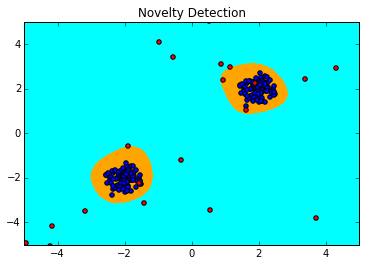

In [6]:
%sql drop table if exists Z_D;
%sql SELECT madlib.svm_predict('svm_out1', 'grid_points', 'index', 'Z_D');
Z_D = %sql SELECT decision_function from Z_D
Z = np.array(Z_D)
Z = Z.reshape(xx.shape)

plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='orange')
plt.contourf(xx, yy, Z, levels=[Z.min(), 0], colors='cyan')
# plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 7), cmap=plt.cm.Blues_r)


b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='blue')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.show()